In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import scipy.io
import cv2

drive.mount('/content/drive', force_remount=True)
mat_file_path0 = '/content/drive/MyDrive/Colab Notebooks/studentdata0.mat'
mat_file_path1 = '/content/drive/MyDrive/Colab Notebooks/studentdata1.mat'
mat_file_path2 = '/content/drive/MyDrive/Colab Notebooks/studentdata2.mat'
mat_file_path3 = '/content/drive/MyDrive/Colab Notebooks/studentdata3.mat'
mat_file_path4 = '/content/drive/MyDrive/Colab Notebooks/studentdata4.mat'
mat_file_path5 = '/content/drive/MyDrive/Colab Notebooks/studentdata5.mat'
mat_file_path6 = '/content/drive/MyDrive/Colab Notebooks/studentdata6.mat'
mat_file_path7 = '/content/drive/MyDrive/Colab Notebooks/studentdata7.mat'

Mounted at /content/drive


In [ ]:
from __future__ import annotations
from math import pi
from typing import Dict, List, NamedTuple, Optional, Tuple, Union
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Rodrigues, solvePnP
from scipy.io import loadmat

class ImagePoint(NamedTuple):
    # holds pixel coordinates in a 2D space
    pixel_x: int
    pixel_y: int

    def to_coordinates() -> Point3D:
        # placeholder method to convert 2D pixel coordinates to 3D coordinates
        pass

class Point3D(NamedTuple):
    # represents a point in 3D space
    coord_x: float
    coord_y: float
    coord_z: float = 0.0

class TagLayout(NamedTuple):
    # describes layout of an individual tag, including its identifier and corners
    tag_id: int  # unique identifier for the tag
    bottomLeftCorner: Point3D
    bottomRightCorner: Point3D
    topRightCorner: Point3D
    topLeftCorner: Point3D

class MeasurementData(NamedTuple):
    # stores all relevant data captured from a sensor measurement
    imageData: np.ndarray # image data captured during measurement
    tagList: List[TagLayout] # list of tags identified
    dataTime: float # timestamp of measurement
    rotationRpy: np.ndarray  # roll, pitch, and yaw data
    accelVector: np.ndarray  # acceleration data
    angularVelocity: np.ndarray  # angular velocity data

class TruePose(NamedTuple):
    # represents true pose of an object as measured
    dataTime: float # timestamp of the pose data
    position_x: float
    position_y: float
    position_z: float
    rotationRoll: float
    rotationPitch: float
    rotationYaw: float
    velocity_x: float
    velocity_y: float
    velocity_z: float
    angularVelocity_x: float
    angularVelocity_y: float
    angularVelocity_z: float

class LayoutMap:
    def __init__(self, tagPositions: Optional[Dict[int, Point3D]] = None, camMat: Optional[np.ndarray] = None, disCoeff: Optional[np.ndarray] = None,):
        # initialize tag positions, camera matrix, and distortion coefficients
        if tagPositions is None:
            self.givenLayout()
        else:
            self.tagPositions = tagPositions

        if camMat is None:
            # default camera intrinsic matrix
            self.camMat = np.array([[314.1779, 0, 199.4848], [0, 314.2218, 113.7838], [0, 0, 1]])
        else:
            self.camMat = camMat

        if disCoeff is None:
            # default camera distortion coefficients
            self.disCoeff = np.array([-0.438607, 0.248625, 0.00072, -0.000476, -0.0911])
        else:
            self.disCoeff = disCoeff

    def givenLayout(self):
        # sets a default layout for tag positions in a grid formation
        self.tagPositions = {}
        columnOffsetIncrement = 0.178 - 0.152
        tagGrid = [[0, 12, 24, 36, 48, 60, 72, 84, 96],
                   [1, 13, 25, 37, 49, 61, 73, 85, 97],
                   [2, 14, 26, 38, 50, 62, 74, 86, 98],
                   [3, 15, 27, 39, 51, 63, 75, 87, 99],
                   [4, 16, 28, 40, 52, 64, 76, 88, 100],
                   [5, 17, 29, 41, 53, 65, 77, 89, 101],
                   [6, 18, 30, 42, 54, 66, 78, 90, 102],
                   [7, 19, 31, 43, 55, 67, 79, 91, 103],
                   [8, 20, 32, 44, 56, 68, 80, 92, 104],
                   [9, 21, 33, 45, 57, 69, 81, 93, 105],
                   [10, 22, 34, 46, 58, 70, 82, 94, 106],
                   [11, 23, 35, 47, 59, 71, 83, 95, 107],]
        # iterate over each row of tag grid
        for yIndex, currentRow in enumerate(tagGrid):
            # iterate over each column within current row
            for xIndex, tagIdentifier in enumerate(currentRow):
                # calculate x position of tag, multiplying index by set distance between tags
                xPosition = 0.152 * (yIndex * 2)
                # calculate y position, adjusting for additional offsets after third and sixth columns
                yPosition = 0.152 * (xIndex * 2)
                if xIndex >= 3:
                    yPosition += columnOffsetIncrement
                if xIndex >= 6:
                    yPosition += columnOffsetIncrement
               # define corners of tag based on its x and y positions
                topLeftCorner = Point3D(xPosition, yPosition, 0)
                topRightCorner = Point3D(xPosition, yPosition + 0.152, 0)
                bottomRightCorner = Point3D(xPosition + 0.152, yPosition + 0.152, 0)
                bottomLeftCorner = Point3D(xPosition + 0.152, yPosition, 0)
                # store tag layout based on its identifier
                self.tagPositions[tagIdentifier] = TagLayout(
                    tag_id=str(tagIdentifier), bottomLeftCorner=bottomLeftCorner, bottomRightCorner=bottomRightCorner,
                    topRightCorner=topRightCorner, topLeftCorner=topLeftCorner,)

    def getPose(self, obsTags: List[TagLayout]) -> Tuple[np.ndarray, np.ndarray]:
        #calculates pose of drone based on observed April Tag markers
        #Parameters: obsTags (List[TagLayout]): List of April Tag objects observed in  image
        #Returns: tuple containing orientation and position of  drone
        # convert tag corner locations from observed tags to a flat array for PnP solving
        worldPts = np.array([
            getattr(self.tagPositions[tag.tag_id], corner)
            for tag in obsTags
            for corner in ['bottomLeftCorner', 'bottomRightCorner', 'topRightCorner', 'topLeftCorner']
            ], dtype=np.float32).reshape(-1, 3)

        # convert image points of tags to a flat array for PnP solving
        imgPts = np.array([
            getattr(tag, corner)
            for tag in obsTags
            for corner in ['bottomLeftCorner', 'bottomRightCorner', 'topRightCorner', 'topLeftCorner']
        ], dtype=np.float32).reshape(-1, 2)

        # ensure there are enough points to perform pose estimation
        if worldPts.shape[0] < 4 or imgPts.shape[0] < 4:
            raise ValueError("Not enough points to estimate pose.")

        # solve PnP problem to obtain rotation and translation vectors
        success, rotVector, getVector = solvePnP(worldPts, imgPts, self.camMat, self.disCoeff, flags=cv2.SOLVEPNP_ITERATIVE)

        if not success:
            raise ValueError("solvePnP failed to find a solution")

        # convert rotation vector to a rotation matrix
        rotMat, _ = Rodrigues(rotVector)
        # reshape translation vector for consistency
        getVector = getVector.reshape(-1, 1)
        # combine rotation matrix and translation vector into a camera-to-world transform matrix
        camWorldTransf = np.hstack((rotMat, getVector))
        # add fourth row to make it a homogeneous transformation matrix
        camWorldTransf = np.vstack((camWorldTransf, [0, 0, 0, 1]))
        # define rotation matrices for adjusting coordinate system from camera to drone frame
        rotZ = np.array([[np.cos(np.pi / 4), -np.sin(np.pi / 4), 0], [np.sin(np.pi / 4), np.cos(np.pi / 4), 0], [0, 0, 1]])
        rotX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
        getRot = np.dot(rotX, rotZ)
        # add fourth row to make it a homogeneous transformation matrix
        getRot = np.vstack((getRot, [0, 0, 0]))
        # define translation offset for camera in drone frame
        camOffset = np.array([-0.04, 0, -0.03, 1]).reshape(4, 1)
        # combine rotation and translation to create camera-to-drone frame transformation
        camDroneFrame = np.hstack((getRot, camOffset))
        # calculate world-to-drone transformation matrix
        worldDroneTransf = np.dot(np.linalg.inv(camWorldTransf), camDroneFrame)
        # extract position vector
        extractPos = worldDroneTransf[:3, -1]
        # convert rotation matrix to Euler angles
        extractOr = rotMatToEuler(worldDroneTransf[:3, :3])
        # return orientation and position of drone
        return extractOr, extractPos

def rotMatToEuler(rotMatrix: np.ndarray) -> Tuple[float, float, float]:
    # extract rotation elements
    m11, m12, m13 = rotMatrix[0]
    m21, m22, m23 = rotMatrix[1]
    m31, m32, m33 = rotMatrix[2]

    # Check for gimbal lock cases where pitch is near +/- 90 degrees
    if np.isclose(m31, 1, atol=1e-8):
        rotYaw = 0
        rotPitch = -np.pi / 2
        rotRoll = np.arctan2(-m23, m22)
    elif np.isclose(m31, -1, atol=1e-8):
        rotYaw = 0
        rotPitch = np.pi / 2
        rotRoll = np.arctan2(m23, m22)
    else:
        # Compute yaw, pitch, roll
        rotPitch = -np.arcsin(m31)  # Pitch is negative as per equation, m31 = sin(pitch)
        rotYaw = np.arctan2(m32 / np.cos(rotPitch), m33 / np.cos(rotPitch))  # m32 = sin(yaw)cos(pitch), m33 = cos(yaw)cos(pitch)
        rotRoll = np.arctan2(m21 / np.cos(rotPitch), m11 / np.cos(rotPitch))  # m21 = sin(roll)cos(pitch), m11 = cos(roll)cos(pitch)

    return rotYaw, rotPitch, rotRoll

def getYawPitchRoll(rotationVector: np.ndarray) -> Tuple[float, float, float]:
    # convert 3x1 Rodrigues rotation vector to a rotation matrix
    rotMatrix, _ = cv2.Rodrigues(rotationVector)

    # extract yaw, pitch, and roll from rotation matrix
    calculatedYaw = np.arctan2(rotMatrix[1, 0], rotMatrix[0, 0])
    calculatedPitch = np.arctan2(-rotMatrix[2, 0], np.sqrt(rotMatrix[2, 1] ** 2 + rotMatrix[2, 2] ** 2))
    calculatedRoll = np.arctan2(rotMatrix[2, 1], rotMatrix[2, 2])

    return calculatedYaw, calculatedPitch, calculatedRoll

def parseData(filepath: str) -> Tuple[List[MeasurementData], List[TruePose]]:
    # load MATLAB file data
    loadedData = loadmat(filepath, simplify_cells=True)
    rawData = loadedData["data"]
    timeStampsData = loadedData["time"]
    viconData = loadedData["vicon"]
    data: List[MeasurementData] = []
    # process each entry in raw data
    for tagIndex, datum in enumerate(rawData):
        tagList: List[TagLayout] = []
        # normalize single id to list if necessary
        if isinstance(datum["id"], int):
            datum["id"] = [datum["id"]]
            for tagCorner in ["p1", "p2", "p3", "p4"]:
                datum[tagCorner] = [[datum[tagCorner][0]], [datum[tagCorner][1]]]
        # build tag layout for each tag id
        for tagIndex, id in enumerate(datum["id"]):
            tagList.append(
                TagLayout(
                    tag_id=id,
                    bottomLeftCorner=ImagePoint(datum["p1"][0][tagIndex], datum["p1"][1][tagIndex]),
                    bottomRightCorner=ImagePoint(datum["p2"][0][tagIndex], datum["p2"][1][tagIndex]),
                    topRightCorner=ImagePoint(datum["p3"][0][tagIndex], datum["p3"][1][tagIndex]),
                    topLeftCorner=ImagePoint(datum["p4"][0][tagIndex], datum["p4"][1][tagIndex]),))

        omg = datum.get("drpy", datum.get("omg"))
        # create and append measurement data object
        data.append(MeasurementData(imageData=datum["img"], tagList=tagList, dataTime=datum["t"], rotationRpy=datum["rpy"],  accelVector=datum["acc"], angularVelocity=omg,))
    # build list of true pose data using time stamps
    groundTruth = [
        TruePose(
            dataTime=dataTime,
            position_x=position_x, position_y=position_y, position_z=position_z,
            rotationRoll=rotationRoll, rotationPitch=rotationPitch, rotationYaw=rotationYaw,
            velocity_x=velocity_x, velocity_y=velocity_y, velocity_z=velocity_z,
            angularVelocity_x=angularVelocity_x, angularVelocity_y=angularVelocity_y, angularVelocity_z=angularVelocity_z)

        for dataTime, (position_x, position_y, position_z, rotationRoll, rotationPitch, rotationYaw, velocity_x, velocity_y, velocity_z, angularVelocity_x, angularVelocity_y, angularVelocity_z)
         in zip(timeStampsData, zip(*viconData))
    ]

    return data, groundTruth

def genEstimatedPose(gts: List[TruePose], estimation: MeasurementData) -> np.ndarray:

    gtTimestamps = np.array([gt.dataTime for gt in gts])
    estimationTime = estimation.dataTime

    closestIndex = np.searchsorted(gtTimestamps, estimationTime)
    if closestIndex == 0 or closestIndex == len(gtTimestamps):
        raise ValueError("Timestamp out of bounds of ground truth data.")

    previousGT, nextGT = gts[closestIndex-1], gts[closestIndex]

    timeBefore = estimationTime - previousGT.dataTime
    timeAfter = nextGT.dataTime - estimationTime
    timeSpan = timeAfter + timeBefore

    attrs = ['position_x', 'position_y', 'position_y', 'rotationRoll', 'rotationPitch', 'rotationYaw']
    previousVector = np.array([getattr(previousGT, attr) for attr in attrs])
    nextVector = np.array([getattr(nextGT, attr) for attr in attrs])

    smoothedPose = (timeAfter / timeSpan) * previousVector + (timeBefore / timeSpan) * nextVector
    return smoothedPose.reshape(6, 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Position: [ 0.20613802 -0.08776253  0.88287675], Orientation: (0.16075901790013855, 0.3938520066009163, 0.3728527997909626)
Position: [-0.10174857  0.26594701  0.87454818], Orientation: (-0.32749758625279174, 0.16860209408438653, 0.231484054464023)
Position: [-0.09943763  0.26019716  0.88229547], Orientation: (-0.31480014837622067, 0.15687277316962586, 0.23789543631452417)
Position: [ 0.19295005 -0.05471392  0.90404532], Orientation: (0.12589245726590184, 0.3532162571001541, 0.3488416486534941)
Position: [ 0.19884601 -0.02436877  0.91891789], Orientation: (0.09781799312347815, 0.3549102558088296, 0.33790458581658017)


<ipython-input-166-9535939c4e8f>:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes.dist = 10
<ipython-input-166-9535939c4e8f>:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes.dist = 10
<ipython-input-166-9535939c4e8f>:21: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes.dist = 10


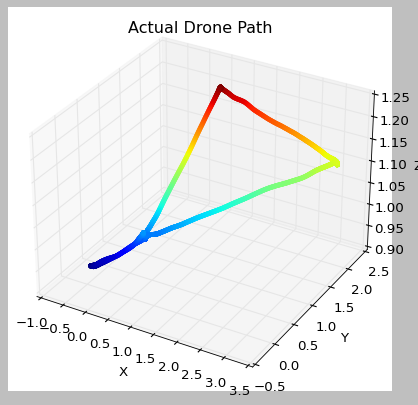

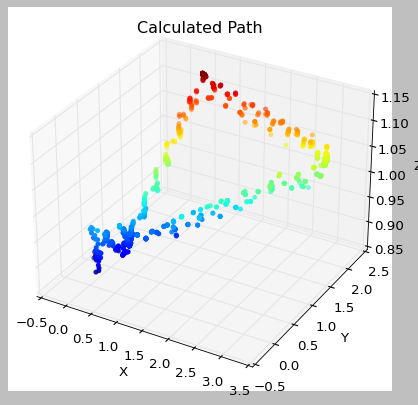

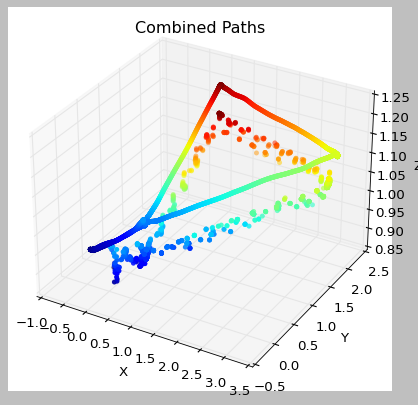

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from typing import List, Optional, Tuple

def get3DPlots(plotTitle: str, *labelDataPairs, figsize: Tuple[int, int] = (10, 6)) -> plt.Figure:
    with plt.style.context('classic'):
      # check for valid label and data pairs
      if labelDataPairs is None or len(labelDataPairs) == 0:
          raise ValueError("No plotting arguments provided")
      elif len(labelDataPairs) % 2 != 0:
          raise ValueError("Arguments must be in pairs of label and data")
      # initialize figure for 3D plotting
      plotFigure = plt.figure(figsize=figsize)
      axes = plt.axes(projection="3d")
      axes.set_xlabel("X")
      axes.set_ylabel("Y")
      axes.set_zlabel("Z")
      axes.dist = 10
      axes.set_title(plotTitle)
      # unpack data pairs for plotting
      labelDataPairs = list(labelDataPairs)
      while labelDataPairs:
          dataLabel = labelDataPairs.pop(0)
          readings = labelDataPairs.pop(0)
          # plot each dataset
          axes.scatter3D([coord[0] for coord in readings], [coord[1] for coord in readings], [coord[2] for coord in readings],
              c=[coord[2] for coord in readings], linewidths=0.5, label=dataLabel,)

      return plotFigure

mat_file_path0 = '/content/drive/MyDrive/Colab Notebooks/studentdata0.mat'
#measurementData, groundTruthData = parseData(mat_file_path0)
#measurementData, groundTruthData = parseData(mat_file_path1)
#measurementData, groundTruthData = parseData(mat_file_path2)
#measurementData, groundTruthData = parseData(mat_file_path3)
#measurementData, groundTruthData = parseData(mat_file_path4)
#measurementData, groundTruthData = parseData(mat_file_path5)
#measurementData, groundTruthData = parseData(mat_file_path6)

# parse data for visualization
measurementData, groundTruthData = parseData(mat_file_path7)

# initialize position mapper
poseMapper = LayoutMap()
estimatedPositions: List[np.ndarray] = []
estimatedOrientations: List[np.ndarray] = []
measurementTimes: List[float] = []
smoothedGT: List[np.ndarray] = []
displayCount = 0

# process each data point
for datum in measurementData:
    if len(datum.tagList) == 0:
        continue

    try:
        # interpolate ground truth pose
        smoothedGT.append(genEstimatedPose(groundTruthData, datum))
    except Exception as e:
        print(f"Error in interpolation: {e}")
        continue
    # get pose from tag data
    tempOrientation, tempPosition = poseMapper.getPose(datum.tagList)
    estimatedPositions.append(tempPosition)
    estimatedOrientations.append(tempOrientation)
    measurementTimes.append(datum.dataTime)
    # display limited number of positions and orientations
    if displayCount < 5:
        print(f"Position: {tempPosition}, Orientation: {tempOrientation}")
        displayCount += 1

plt.show()

# gather data for plotting
groundTruthTrajectory = [(groundTruthData.position_x, groundTruthData.position_y, groundTruthData.position_z) for groundTruthData in groundTruthData]
predictedTrajectory = [(position[0], position[1], position[2]) for position in estimatedPositions]
# plot ground truth and estimated trajectories
groundTruthTrajectoryFig = get3DPlots("Actual Drone Path", "GD", groundTruthTrajectory, figsize=(10, 6))
predictedTrajectoryFig = get3DPlots("Calculated Path", "Cam Estimation", predictedTrajectory, figsize=(10, 6))
combinedFig = get3DPlots("Combined Paths", "GD", groundTruthTrajectory, "Cam Estimation", predictedTrajectory, figsize=(10, 6))

# display
groundTruthTrajectoryFig.show()
predictedTrajectoryFig.show()
combinedFig.show()

In [ ]:
from typing import List
import numpy as np

# function estimates covariance matrix based on true pose, estimated positions, orientations, and sensor data.
def estimateCovariance(groundTruth: List[TruePose], getPositions: List[np.ndarray], getOrientations: List[np.ndarray], data: List[MeasurementData],) -> np.ndarray:
    errorSum = np.zeros((6, 6))
    validSamples = 0

    # loop through corresponding elements of data and ground truth
    for estimation, localPosition, localOrientation in zip(data, getPositions, getOrientations):
        if estimation.dataTime < groundTruth[0].dataTime:
            continue

        try:
            # generate an estimated pose to compare against measurement
            smoothedState = genEstimatedPose(groundTruth, estimation)
        except ValueError:
            continue

        # combine position and orientation into a single state vector
        estimatedState = np.concatenate([
            np.ravel(localPosition),  # convert to 1D array if not already.
            np.ravel(localOrientation)  # convert to 1D array if not already.
        ]).reshape(6, 1)

        # calculate error vector and accumulate sum
        stateError = smoothedState - estimatedState
        errorSum += stateError @ stateError.T
        validSamples += 1

    # compute average covariance matrix if there are enough valid samples
    if validSamples > 1:
        avgCov = errorSum / (validSamples - 1)
    else:
        raise ValueError("Not enough data to estimate covariances.")

    return avgCov

# function generates an estimated pose based on data from ground truth and current measurement
def genEstimatedPose(gts: List[TruePose], estimation: MeasurementData) -> np.ndarray:
    # filter ground truths to find adjacent points for interpolation
    adjacentGTs = [gt for gt in gts if gt.dataTime <= estimation.dataTime]
    if not adjacentGTs:
        raise ValueError("Estimation precedes all ground truths.")
    previousGT = adjacentGTs[-1]
    try:
        nextGT = gts[len(adjacentGTs)]
    except IndexError:
        raise ValueError("No ground truth found after the estimation timestamp.")
    # compute interpolation weights and perform interpolation
    totalDelta = nextGT.dataTime - previousGT.dataTime
    weightA = (nextGT.dataTime - estimation.dataTime) / totalDelta
    weightB = 1 - weightA
    # combine weighted vectors to get interpolated pose
    interpolatedPose = weightA * np.array([previousGT.position_x, previousGT.position_y, previousGT.position_z, previousGT.rotationRoll, previousGT.rotationPitch, previousGT.rotationYaw]) \
                       + weightB * np.array([nextGT.position_x, nextGT.position_y, nextGT.position_z, nextGT.rotationRoll, nextGT.rotationPitch, nextGT.rotationYaw])

    return interpolatedPose.reshape(6, 1)


if __name__ == "__main__":
    selectedDataset = mat_file_path0
    #selectedDataset = mat_file_path1
    #selectedDataset = mat_file_path2
    #selectedDataset = mat_file_path3
    #selectedDataset = mat_file_path4
    #selectedDataset = mat_file_path5
    #selectedDataset = mat_file_path6
    #selectedDataset = mat_file_path7

    # parse data using selected dataset
    readings, groundTruth = parseData(selectedDataset)
    # initialize a LayoutMap object
    getInstance = LayoutMap()

    # initialize lists to hold processed data
    estimatedPositions: List[np.ndarray] = []
    estimatedOrientations: List[np.ndarray] = []
    validData: List[readings] = []

    # process data from dataset
    for datum in readings:
        if len(datum.tagList) == 0:
            continue
        validData.append(datum)
        # get pose estimations for each datum
        tempOrientation, tempPosition = getInstance.getPose(datum.tagList)
        estimatedPositions.append(tempPosition)
        estimatedOrientations.append(getYawPitchRoll(tempOrientation))

    # estimate covariance matrix based on gathered data
    avgCov = estimateCovariance(groundTruth, estimatedPositions, estimatedOrientations, validData)
    print("----------------------------------------------------------------------")
    print(f"Print results: {selectedDataset}")
    print(avgCov)
    print("----------------------------------------------------------------------")

----------------------------------------------------------------------
Print results: /content/drive/MyDrive/Colab Notebooks/studentdata0.mat
[[ 0.01124641 -0.00167305 -0.00189018  0.00532129 -0.00396055 -0.00028349]
 [-0.00167305  0.00544109  0.0002523  -0.00102443  0.00326998 -0.00467435]
 [-0.00189018  0.0002523   0.00119224 -0.00165101  0.00271911  0.00011026]
 [ 0.00532129 -0.00102443 -0.00165101  0.00633645 -0.00593225 -0.00243686]
 [-0.00396055  0.00326998  0.00271911 -0.00593225  0.0146031  -0.00101018]
 [-0.00028349 -0.00467435  0.00011026 -0.00243686 -0.00101018  0.00723985]]
----------------------------------------------------------------------


<ipython-input-175-c4de1f4c8d9c>:20: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axes.dist = 10


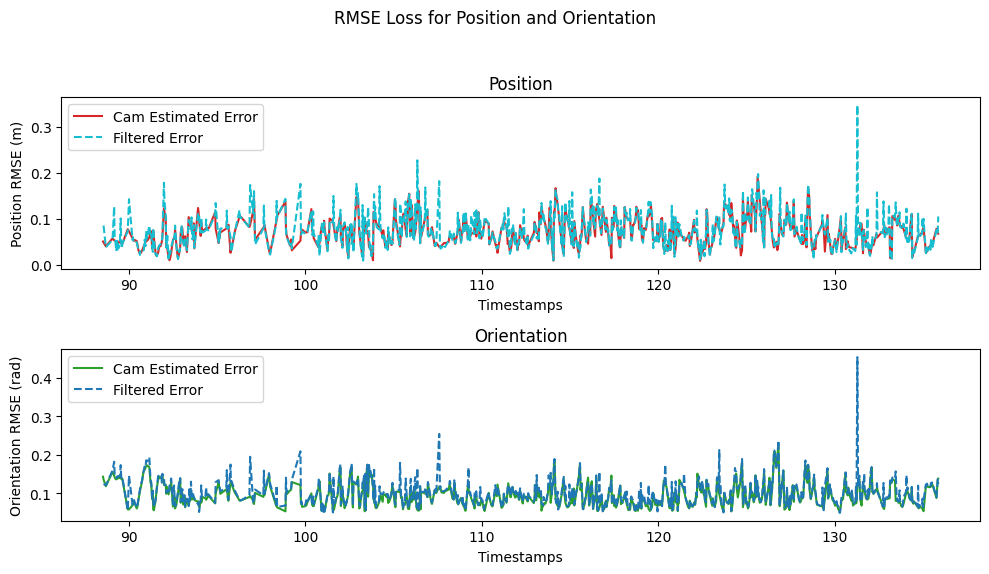

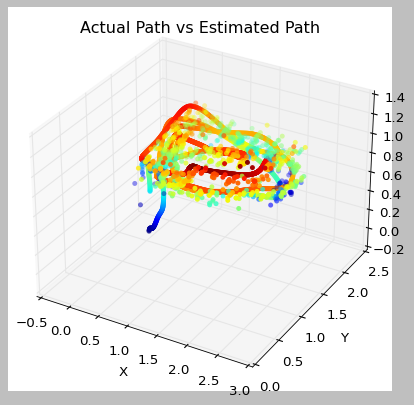

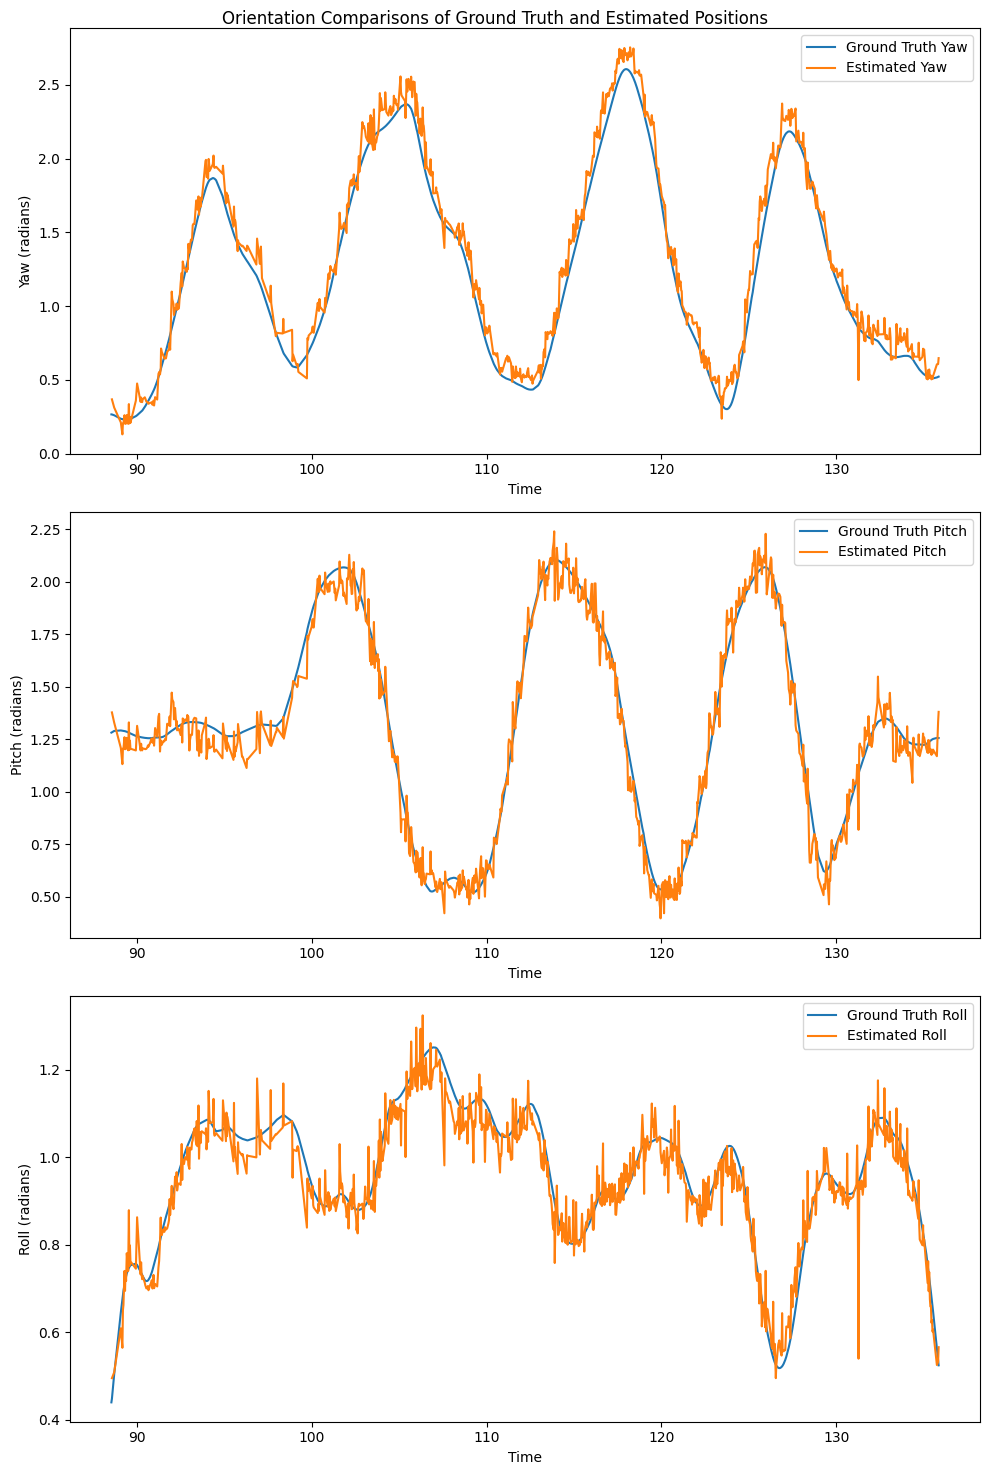

In [ ]:
import numpy as np
from time import time
from typing import List, Optional, Tuple
from scipy.linalg import sqrtm

# function to create 3D scatter plots
def get3DPlots(plotTitle: str, *labelDataPairs, figsize: Tuple[int, int] = (10, 6)) -> plt.Figure:
    with plt.style.context('classic'):
      if labelDataPairs is None or len(labelDataPairs) == 0:
          raise ValueError("No plotting arguments provided")
      elif len(labelDataPairs) % 2 != 0:
          raise ValueError("Arguments must be in pairs of label and data")

      # initialize figure and 3D axes for plot
      plotFigure = plt.figure(figsize=figsize)
      axes = plt.axes(projection="3d")
      axes.set_xlabel("X")
      axes.set_ylabel("Y")
      axes.set_zlabel("Z")
      axes.dist = 10
      axes.set_title(plotTitle)

      # loop through label and data pairs and add them to scatter plot
      labelDataPairs = list(labelDataPairs)
      while labelDataPairs:
          dataLabel = labelDataPairs.pop(0)
          readings = labelDataPairs.pop(0)
          axes.scatter3D([coord[0] for coord in readings], [coord[1] for coord in readings], [coord[2] for coord in readings],
              c=[coord[2] for coord in readings], linewidths=0.5, label=dataLabel,)

      return plotFigure

# function to create RMSE charts for position and orientation
def getRMSECharts(GTs, cameraPoses, states, timestamps, figsize=(10, 6)) -> plt.Figure:
    # extract positions and orientations from inputs
    gt_pos = np.array([gt[:3] for gt in GTs]).reshape(-1, 3)
    gt_orientations = np.array([gt[3:6] for gt in GTs]).reshape(-1, 3)
    camera_pos = np.array([estimate[:3] for estimate in cameraPoses]).reshape(-1, 3)
    camera_orientations = np.array([estimate[3:6] for estimate in cameraPoses]).reshape(-1, 3)
    states_pos = np.array([state[:3] for state in states]).reshape(-1, 3)
    states_orientations = np.array([state[3:6] for state in states]).reshape(-1, 3)

    # calculate RMSE for position and orientation for camera estimates
    camera_position_rmse = np.sqrt(np.mean((gt_pos - camera_pos) ** 2, axis=1))
    camera_orientation_rmse = np.sqrt(np.mean((gt_orientations - camera_orientations) ** 2, axis=1))

    # calculate RMSE for position and orientation for filter states
    skip_first = 0 if len(gt_pos) == len(states_pos) else 1
    state_position_rmse = np.sqrt(np.mean((gt_pos[skip_first:] - states_pos) ** 2, axis=1))
    state_orientation_rmse = np.sqrt(np.mean((gt_orientations[skip_first:] - states_orientations) ** 2, axis=1))

    rmse_figure, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    rmse_figure.suptitle("RMSE Loss for Position and Orientation")

    # position RMSE
    ax1.plot(timestamps, camera_position_rmse, label="Cam Estimated Error", color='tab:red')
    ax1.plot(timestamps[1:], state_position_rmse, label="Filtered Error", color='tab:cyan', linestyle='--')
    ax1.set_title("Position")
    ax1.set_xlabel("Timestamps")
    ax1.set_ylabel("Position RMSE (m)")
    ax1.legend()

    # orientation RMSE
    ax2.plot(timestamps, camera_orientation_rmse, label="Cam Estimated Error", color='tab:green')
    ax2.plot(timestamps[1:], state_orientation_rmse, label="Filtered Error", color='tab:blue', linestyle='--')
    ax2.set_title("Orientation")
    ax2.set_xlabel("Timestamps")
    ax2.set_ylabel("Orientation RMSE (rad)")
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return rmse_figure

def getOriPlots(ground_truth: List[np.ndarray], estimates: List[np.ndarray], timestamps: List[float]) -> plt.Figure:
    # extract estimated orientations
    yaw_estimated = [orientation[0] for orientation in estimates]
    pitch_estimated = [orientation[1] for orientation in estimates]
    roll_estimated = [orientation[2] for orientation in estimates]

    # extract ground truth orientations
    yaw_gt = [gt[0] for gt in ground_truth]
    pitch_gt = [gt[1] for gt in ground_truth]
    roll_gt = [gt[2] for gt in ground_truth]

    # create a figure with three subplots, one for each orientation component
    orientations_figure, axs = plt.subplots(3, 1, figsize=(10, 15))
    orientations_figure.suptitle("Orientation Comparisons of Ground Truth and Estimated Positions")
    estimate_timestamps = timestamps if len(timestamps) == len(estimates) else timestamps[1:]

    # yaw plot
    axs[0].plot(timestamps, yaw_gt, label="Ground Truth Yaw")
    axs[0].plot(estimate_timestamps, yaw_estimated, label="Estimated Yaw")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Yaw (radians)")
    axs[0].legend()

    # pitch plot
    axs[1].plot(timestamps, pitch_gt, label="Ground Truth Pitch")
    axs[1].plot(estimate_timestamps, pitch_estimated, label="Estimated Pitch")
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Pitch (radians)")
    axs[1].legend()

    # roll plot
    axs[2].plot(timestamps, roll_gt, label="Ground Truth Roll")
    axs[2].plot(estimate_timestamps, roll_estimated, label="Estimated Roll")
    axs[2].set_xlabel("Time")
    axs[2].set_ylabel("Roll (radians)")
    axs[2].legend()

    plt.tight_layout()
    return orientations_figure

class unscentedKalmanFilter:

    def __init__(self, measCovMat: Optional[np.ndarray] = None, scalingFactor: float = 1, sigmaPointSpread: float = 1, distributionShape: float = 2.0,):
        # initialize filter parameters and state dimensions
        self.stateDimension = 15
        self.scalingFactor = scalingFactor
        self.sigmaPointSpread = sigmaPointSpread
        self.distributionShape = distributionShape
        # measurement covariance matrix, default or provided
        self.measCovMat = avgCov
        # calculate number of sigma points
        self.sigmaPts = 2 * self.stateDimension + 1
        # compute lambda for sigma point calculations
        self.lamb = self.sigmaPointSpread ** 2 * (self.stateDimension + self.scalingFactor) - self.stateDimension
        tempLambda = self.lamb + self.stateDimension
        # initialize weights for mean and covariance calculations
        self.meanWeights = np.full(self.sigmaPts, 1 / (2 * tempLambda))
        self.covWeights = np.full(self.sigmaPts, 1 / (2 * tempLambda))
        # adjust first weight differently based on lambda
        self.meanWeights[0] = self.lamb / tempLambda
        self.covWeights[0] = self.lamb / tempLambda + 1 - self.sigmaPointSpread ** 2 + self.distributionShape
        # instance of map for state vector calculations
        self.map = LayoutMap()

    def getSigmaPts(self, meanState: np.ndarray, covarianceMatrix: np.ndarray) -> np.ndarray:
        # create sigma points array
        sigmaPts = np.zeros((self.sigmaPts, self.stateDimension, 1))
        # first sigma point is the mean state
        sigmaPts[0] = meanState
        # calculate square root of scaled covariance matrix
        spreadMatrix = sqrtm((self.stateDimension + self.scalingFactor) * covarianceMatrix)
        # generate sigma points based on distribution around mean
        for i in range(self.stateDimension):
            sigmaPts[i + 1] = meanState + spreadMatrix[i].reshape((15, 1))
            sigmaPts[self.stateDimension+ i + 1] = meanState - spreadMatrix[i].reshape((15, 1))

        return sigmaPts

    def dynamicUpdate(self, state: np.ndarray, deltat: float, ua: np.ndarray, uw: np.ndarray) -> np.ndarray:
        # extract angles/linear velocity from state
        rollAngle, pitchAngle, yawAngle = state[3:6, 0]
        velocityVector = state[6:9, 0]
        gravity = -9.8

        # compute rotation matrices for transformation
        cosTheta, sinTheta = np.cos(rollAngle), np.sin(rollAngle)
        cosPhi, sinPhi = np.cos(pitchAngle), np.sin(pitchAngle)
        cosPsi, sinPsi = np.cos(yawAngle), np.sin(yawAngle)

        # inverse transformation from body to world frame
        inverseBodytoWorldTf = np.array([[cosTheta, 0, sinTheta], [sinPhi * sinTheta / cosPhi, 1.0, -cosTheta * sinPhi / cosPhi], [-sinTheta / cosPhi, 0, cosTheta / cosPhi]])

        # rotation matrix from body to world coordinates
        bodytoWorldRotation = np.array([
            [cosPsi * cosTheta - sinPhi * sinPsi * sinTheta, -cosPhi * sinPsi, cosPsi * sinTheta + cosTheta * sinPhi * sinPsi],
            [cosTheta * sinPsi + cosPsi * sinPhi * sinTheta, cosPhi * cosPsi, sinPsi * sinTheta - cosPsi * cosTheta * sinPhi],
            [-cosPhi * sinTheta, sinPhi, cosPhi * cosTheta]])

        # compute derivatives of position and orientations
        pdot = velocityVector
        omgTf = inverseBodytoWorldTf @ uw
        accTf = gravity + bodytoWorldRotation @ ua
        # calculate total derivatives and update state
        xdot = np.concatenate((pdot, omgTf, accTf, np.zeros(6)))[:, np.newaxis]
        newState = state + xdot * deltat

        return newState

    def correctState(self, state: np.ndarray, estimatedMean: np.ndarray, sigma: np.ndarray, sigmaPts) -> np.ndarray:
        # initialize predicted measurements array for each sigma point
        predictedMeasurements = np.zeros_like(sigmaPts)
        # fill predicted measurements by transforming each sigma point
        for i in range(self.sigmaPts):
            predictedMeasurements[i] = self.stateToMeeasurement(sigmaPts[i])
        # initialize mean of predicted measurements
        predictedStateMean = np.zeros((self.stateDimension, 1))
        # compute mean of predicted measurements using weighted average
        for i in range(0, self.sigmaPts):
            predictedStateMean += self.meanWeights[i] * predictedMeasurements[i]
        # initialize measurement noise covariance matrix
        measurementNoiseCov = np.zeros((self.stateDimension, self.stateDimension))
        measurementNoiseCov[0:6, 0:6] = np.diag(self.measCovMat)
        measurementCovariance = np.zeros((self.stateDimension, self.stateDimension))
        # calculate prediction errors
        predictionErrors = predictedMeasurements - predictedStateMean
        # compute measurement covariance matrix using prediction errors and weights
        for i in range(0, self.sigmaPts):
            measurementCovariance += self.covWeights[i] * np.dot(predictionErrors[i], predictionErrors[i].T)
        measurementCovariance += measurementNoiseCov

        # initialize cross covariance matrix
        crossCovariance = np.zeros((self.stateDimension, self.stateDimension))
        stateDifferences = sigmaPts - estimatedMean
        # compute cross covariance matrix
        for i in range(0, self.sigmaPts):
            crossCovariance += self.covWeights[i] * np.dot(stateDifferences[i], predictionErrors[i].T)

        # compute kalman gain using pseudo-inverse of measurement covariance matrix
        Kgain = np.dot(crossCovariance, np.linalg.pinv(measurementCovariance))
        # update state using kalman gain and difference between actual state and predicted state mean
        updatedState = estimatedMean + np.dot(Kgain, state - predictedStateMean)
        # update covariance using kalman gain and measurement covariance
        updatedCovariance = sigma - np.dot(Kgain, measurementCovariance).dot(Kgain.T)
        # adjust covariance matrix to ensure it is positive semi-definite
        updatedCovariance = self.adjustCovMat(updatedCovariance)

        return updatedState, updatedCovariance

    def adjustCovMat(self, updatedCovariance: np.ndarray, noise: float = 1e-3):
        # set number of iterations for covariance matrix adjustment
        maxIterations = 10
        # set initial regulation factor for numerical stability
        regulationFactor = noise

        # iteratively adjust covariance matrix
        for _ in range(maxIterations):
            # ensure covariance matrix is symmetric
            updatedCovariance = (updatedCovariance + updatedCovariance.T) / 2
            # compute eigenvalues and eigenvectors of covariance matrix
            eigenValues, eigenVectors = np.linalg.eig(updatedCovariance)
            # if all eigenvalues are positive, matrix is already valid

            if np.all(eigenValues > 0):
                return updatedCovariance
            # adjust eigenvalues to be positive and scale up regulation factor if needed
            eigenValues = np.where(eigenValues > 0, eigenValues, 0) + regulationFactor
            updatedCovariance = eigenVectors.dot(np.diag(eigenValues)).dot(eigenVectors.T)
            # increase regulation factor for next iteration if needed
            regulationFactor *= 10

        return updatedCovariance

    def stateToMeeasurement(self, state: np.ndarray) -> np.ndarray:
        measurementVector = np.zeros((self.stateDimension, 1))
        transformMatrix = np.zeros((6, self.stateDimension))
        transformMatrix[0:6, 0:6] = np.eye(6)

        noiseCovariance = np.diag(self.measCovMat).reshape(6, 1)
        measurementVector[0:6] = np.dot(transformMatrix, state) + noiseCovariance

        return measurementVector

    def statePropagation(self, sigmaPts: np.ndarray, ua: np.ndarray, uw: np.ndarray, deltat: float) -> Tuple[np.ndarray]:
       # initialize an array to hold predicted states for each sigma point
        predictedStates = np.zeros_like(sigmaPts)
        # update each sigma point based on dynamic model
        for i in range(sigmaPts.shape[0]):
            predictedStates[i, :] = self.dynamicUpdate(sigmaPts[i], deltat, uw, ua)
        # calculate mean of predicted states using weights
        predictedMean = np.zeros((self.stateDimension, 1))
        for i in range(0, self.sigmaPts):
            predictedMean += self.meanWeights[i] * predictedStates[i]

        # add some noise to process covariance as a part of uncertainty
        processNoiseCovariance = np.random.normal(scale=5e-1, size=(15, 15))
        stateDifferences = predictedStates - predictedMean
        # get covariance of predicted states
        covariancePrediction = np.zeros((self.stateDimension, self.stateDimension))
        for i in range(0, self.stateDimension):
            covariancePrediction += self.covWeights[i] * np.dot(stateDifferences[i], stateDifferences[i].T)
        covariancePrediction += processNoiseCovariance

        return predictedMean, covariancePrediction, predictedStates

    def stateVectorFromData(self, sensorData: MeasurementData, previousState: np.ndarray, previousTimestamp: float) -> np.ndarray:
        # initialize state vector with zeros
        stateVector = np.zeros((15, 1))
        # obtain pose from sensor data
        orientation, position = self.map.getPose(sensorData.tagList)
         # asign position and orientation to state vector
        stateVector[:3, 0] = position  # Position expected as a flat array
        stateVector[3:6, 0] = orientation  # Orientation expected as a flat array

        return stateVector


    def executeFilter(self, estimatePos: List[MeasurementData]) -> List[np.ndarray]:
        # create initial state vector from first sensor data
        stateVector = self.stateVectorFromData(estimatePos[0], np.zeros((self.stateDimension, 1)), 0.0)
        # initialize velocity part of state vector
        stateVector[6:9] = np.zeros((3, 1))
        # record initial timestamp
        prevTimeStamp = estimatePos[0].dataTime

         # initialize covariance matrix with small uncertainties
        calculateCovMat = np.eye(self.stateDimension) * 1e-3
        filteredPos = []

        # iterate over all sensor data to update state vector
        for data in estimatePos[1:]:

            # update state vector from data
            stateVector = self.stateVectorFromData(data, stateVector, prevTimeStamp)

            deltat = data.dataTime - prevTimeStamp
            prevTimeStamp = data.dataTime
            # generate sigma points for current state
            sigmaPts = self.getSigmaPts(stateVector, calculateCovMat)
            # propagate sigma points through process model
            predictedMean, predictedCovariance, predictedStates = self.statePropagation(sigmaPts, data.accelVector, data.angularVelocity, deltat)
            # correct predicted mean and covariance based on measurements
            updatedMean, updatedCovariance = self.correctState(stateVector, predictedMean, predictedCovariance, predictedStates)
            # update state vector and covariance matrix
            stateVector = updatedMean
            calculateCovMat = updatedCovariance
            # append updated state to list of filtered positions
            filteredPos.append(stateVector)

        return filteredPos

def extractDataFeatures(dataInput, gt):
    # process raw data to generate positions, orientations, times, and measurements
    poseEstimator = LayoutMap()
    data, smoothedGT, cameraPoses = [], [], []

   # loop through each datum in  input data
    for datum in dataInput:
        if not datum.tagList:
            continue
        try:
            # estimate and append smoothed pose to ground truth list
            smoothedGT.append(genEstimatedPose(gt, datum))
            # get pose from LayoutMap object and append to camera poses
            orientation, position = poseEstimator.getPose(datum.tagList)
            cameraPoses.append(np.concatenate([position, orientation]))
            # append processed datum to data list
            data.append(datum)
        except Exception as e:
            print(f"Skipping datum due to error: {e}")
            continue

    return data, smoothedGT, cameraPoses

def ukfWrapper(data):
    # initialize UKF and run filter over data, return results and time taken
    getInstance = unscentedKalmanFilter() # create an instance of UKF class
    init = time() # record start time.
    getFiltered = getInstance.executeFilter(data) # execute filter
    total = time() - init
    return getFiltered, total # return filtered data and time taken

if __name__ == "__main__":
    # uncomment dataset to perform the UKF on that specific dataset
    selectedDataset = mat_file_path0
    #selectedDataset = mat_file_path1
    #selectedDataset = mat_file_path2
    #selectedDataset = mat_file_path3
    #selectedDataset = mat_file_path4
    #selectedDataset = mat_file_path5
    #selectedDataset = mat_file_path6
    #selectedDataset = mat_file_path7

    # parse selected dataset to get readings and ground truth values
    readings, groundTruth = parseData(selectedDataset)
    # extract relevant features from readings for UKF processing
    readings, smoothedGT, cameraPoses = extractDataFeatures(readings, groundTruth)
    # apply unscented kalman filter on readings and measure time taken
    ukfResults, totalTime = ukfWrapper(readings)
    # stack all ukf results into a single array for analysis
    stateArray = np.stack(ukfResults)
    # generate root mean square error charts for position and orientation
    rmsePlots = getRMSECharts(smoothedGT, cameraPoses, stateArray, [d.dataTime for d in readings], figsize=(10, 6))
    # plot 3d trajectories of actual vs estimated paths
    show3DPlot = get3DPlots(
        "Actual Path vs Estimated Path", "GT",
        [Point3D(coord_x=groundTruth[i].position_x, coord_y=groundTruth[i].position_y, coord_z=groundTruth[i].position_z) for i in range(len(groundTruth))], "Estimated UKF",
        [Point3D(coord_x=position[0], coord_y=position[1], coord_z=position[2]) for position in ukfResults],  figsize=(10, 6))
    # generate orientation plots comparing ukf estimates against ground truth
    plotOrientation = getOriPlots(smoothedGT, ukfResults, [d.dataTime for d in readings])
    # display generated RMSE and 3D plots
    rmsePlots.show()
    show3DPlot.show()
    plotOrientation.show()